**Due date is Wednesday, March 10, 2021, 23:59 PST**

**ONLY write into the existing cells, and do NOT delete or add any cells.**

# ELEC 400M / EECE 571M Assignment 2: Neural networks
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will implement a neural network model for multi-class classification. The purpose is to demonstrate an understanding of the basic elements including training of neural network models. Hence, your implementation will be from scratch only using functions from the NumPy library.

The neural network you will be implementing has the following structure:
* 1 input layer, 1 hidden layer with ReLU activation and 1 output layer with Softmax function
* The loss function is the Cross Entropy Loss.
* Training will be done using Gradient Descent with Momentum. 

## Data Set
We again consider the dataset of images of letters in different fonts contained in file notMNIST.npz (which btw is from http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html). This time we consider 10 letters ("A" to "J"), which are all the letters contained in this data set, and we want to classfiy the images according to the letter they display. The figure below shows 30 randomly selected image samples for the letters.

<img src="sample_images_2.png" width="400">

You will apply the function `loadData` given below to load the data set, which includes 18720 images and their labels, which we also refer to as **targets**. This script organizes the data set into training, validation and test sets. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
       
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Data preprocessing [5 points]

Input data: The classification should be based on the $d=28\times 28=784$ intensity values in an image (as for Assignment 1).

Output data: Since you will be performing multi-class classification, the labels will be converted into a one-hot encoding format. 

Please first briefly explain the meaning of one-hot encoding and why it is used (instead of keeping the numerical label values provided by the data set). State an example for a one-hot encoded label for the data set considered in this assignment. Use the text cell below for this. 

After that, implement a function that one-hot encodes the labels (or targets) for the training, validation and test sets

One hot code is used to represent numbers, and letters using 0's and just one 1. This helps us categorize data, there is a need to for data to convert it into a better expression, one of this is one-hot code representation. So for the example above, to represent these letters we will use: (So let A = 0, B = 1, C = 2, ... J = 9)

If we are using 10 letters, then we need to have 10 bits

Then,

A = 1 0 0 0 0 0 0 0 0 0

B = 0 1 0 0 0 0 0 0 0 0

D = 0 0 0 1 0 0 0 0 0 0

J  = 0 0 0 0 0 0 0 0 0 1

In [3]:
def convertOneHot(trainTarget, validTarget, testTarget):
    # YOUR CODE HERE
    n_letters = 10
    # Convert trainTarget
    trainTarget_OH = np.zeros((len(trainTarget), n_letters))
    trainTarget_OH[np.arange(trainTarget.size), trainTarget] = 1
    
    # Convert validTarget
    validTarget_OH = np.zeros((len(validTarget), n_letters))
    validTarget_OH[np.arange(validTarget.size),validTarget] = 1
    
    # Convert testTarget
    testTarget_OH  = np.zeros((len(testTarget), n_letters)) 
    testTarget_OH[np.arange(testTarget.size), testTarget] = 1
    
    return trainTarget_OH, validTarget_OH, testTarget_OH

datas = loadData()
#maxIter = 100
trainData = datas[0].reshape(15000,-1)
trainTarget = datas[3].astype(int)
testTarget  = datas[5].astype(int) # this was making the issue ...
validTarget = datas[4].astype(int)
    
print(len(trainTarget))
print(trainTarget.reshape(15000,-1)) 
print(convertOneHot(trainTarget, validTarget, testTarget)[0])

15000
[[5]
 [9]
 [9]
 ...
 [2]
 [0]
 [9]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


## Structure of the network [2 points]

Sketch the structure of the network to classify the letters from the data set. Identify the dimensions of the network layers, include the activation functions, and do not forget the bias nodes. (You may sketch this by hand and upload a photo of your sketch.)

### MY ANSWER:
<img src="structure_of_network.png" width="1000">

## Helper functions [6 points]
To give the implementation of the network some structure, you will first implement five helper functions. 

Use Numpy arrays for your implementations, and organize data in vectors and matrices as appropriate for compact programming (i.e., avoid `for` loops).

1. `relu`: This function will accept one argument and return the ReLU activation: 
    $$\mathrm{ReLU}(x)=\max(0,x).$$
    
2. `softmax`: This function will accept one argument and return the softmax activations:
    $$ [\sigma(\mathbf{z})]_j = \frac{\mathrm{e}^{z_j}}{\sum\limits_{k=1}^K\mathrm{e}^{z_k}},$$ $j=1,2,\ldots, K$,  for $K$ classes.
    
You may want to program the `relu` and the `softmax` functions that you call them once for all $N$ samples to be processed.    

3. `computeLayer`: This function will accept two arguments, the input vectors $\mathbf{x}^{(\ell-1)}_n$ and the weight matrix $\mathbf{W}^{(\ell)}$ for a layer $\ell$, and return the vectors $\mathbf{s}_n^{(\ell)}=(\mathbf{W}^{(\ell)})^T\mathbf{x}_n^{(\ell)}$, $n=1,2,\ldots,N$, i.e., the inputs to the activation function of that layer (the notation for variables from the textbook is used). Don't forget to account for the bias term (which can be included in augmented vectors $\mathbf{x}^{(\ell)}_n$ as in the textbook).

4. `CE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots, N$. It will return the average cross entropy loss
$$\mathrm{E}_{\mathrm{in}}=-\frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{k=1}^Ky_{n,k}\log([\sigma(\mathbf{s}_n)]_k)$$

5. `gradCE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots, N$. It will return the gradients of the cross entropy loss for each data sample with respect to $\mathbf{s}_n$, i.e., it returns the sensivity vectors for the output layer as introduced in the textbook:
$$\boldsymbol{\mathbf{\delta}}^{(L)}_n=\frac{\partial e_n}{\partial \mathbf{s}_n^{(L)}},\quad n=1,2,\ldots,N.$$. 

First state the analytical expression for the gradient used in `gradCE` and then implement the five helper functions.

### MY ANSWER:

For $$\boldsymbol{\mathbf{\delta}}^{(L)}_n=\frac{\partial e_n}{\partial \mathbf{s}_n^{(L)}},\quad n=1,2,\ldots,N.$$
 
We will use the softmax function and then we will get,
$$\boldsymbol{\mathbf{\delta}}^{(L)}_n=\frac{\partial e_n}{\partial \mathbf{s}_n^{(L)}},\quad = softmax({S}_n^{(L)}) - y_n $$

In [4]:
def relu(x):
    # YOUR CODE HERE
    return np.maximum(0,x)
print(relu(-4))
print(relu(9))

0
9


In [5]:
def softmax(x):    
    # YOUR CODE HERE
    return np.exp(x)/sum(np.exp(x))

print(softmax(np.array([[0,1,2],[2,2,0]])))

[[0.11920292 0.26894142 0.88079708]
 [0.88079708 0.73105858 0.11920292]]


In [6]:
def computeLayer(x,W):
    # YOUR CODE HERE
    return np.dot(W.T,x)
print(computeLayer(np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]]),np.array([[1],[1],[1],[1]])))

[[ 6  8 10]]


In [7]:
def CE(target, softmaxinput):
    # YOUR CODE HERE
    N = len(target[0])
    return -1/N * (np.sum(np.multiply(target, np.log(10**(-18) + softmax(softmaxinput)))))


In [8]:
def gradCE(target, softmaxinput):
    # YOUR CODE HERE
    return softmax(softmaxinput) - target

## Backpropagation [2 points]

The training of the network will be done via backpropagation. First derive the following gradients:
1. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$, where $\mathbf{W}^{\mathrm{o}}$ is the weight matrix of the output layer.

2. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}}$, where $\mathbf{W}^{\mathrm{h}}$ is the weight matrix of the hidden layer.

Write the results using the steps and notation used in the textbook.

### MY ANSWER:
#### 1. 
We got $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$
where $\mathbf{W}^{\mathrm{o}}$ is at the output layer so we can say that:
$$\mathbf{W}^{\mathrm{o}} = \mathbf{W}^{\mathrm{L}}$$ 
where L is the output's layer number.
So we got
$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$ = $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{L}}}$ .

From the book we got $$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{(l)}}} = \frac{1}{N}\sum\limits_{n=1}^N\frac{\partial e_{\mathrm{n}}}{\partial \mathbf{W}^{\mathrm{(l)}}} $$

Furthermore, we got this equation for $\frac{\partial e_{\mathrm{n}}}{\partial \mathbf{W}^{\mathrm{(l)}}} = x^{(l-1)}(\delta^{(l)})^T $

where $\delta^{(l)} = \theta'(s^{(l)}) ⊗ [W^{(l + 1)}\delta^{(l + 1)}]^{d^{(l)}}$

We know that layer = L, and therefore, we will get:
$$ \delta^{(L)} = \theta'(s^{(L)}) ⊗ [W^{(L+ 1)}\delta^{(L+ 1)}]^{d^{(L}}$$

Hence, $\frac{\partial e_{\mathrm{n}}}{\partial \mathbf{W}^{\mathrm{(l)}}} = x^{(l-1)}(\theta'(s^{(L)}) ⊗ [W^{(L+ 1)}\delta^{(L+ 1)}]^{d^{(L)}})^T $

So, 
$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{(l)}}} = \frac{1}{N}\sum\limits_{n=1}^Nx^{(l-1)}(\theta'(s^{(L)}) ⊗ [W^{(L+ 1)}\delta^{(L+ 1)}]^{d^{(L)}})^T $$

Where $\frac{\partial e_{\mathrm{n}}}{\partial \mathbf{W}^{\mathrm{(L}}} = \delta^{(L)}_n $ is a Sensitivity Factor.

#### 2. 
We got $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}}$ where $\mathbf{W}^{\mathrm{h}}$ is at the hidden layer so we can say that: 
$0 < l < L$
$$\mathbf{W}^{\mathrm{h}} = \mathbf{W}^{\mathrm{l}}$$ 
where l is the hidden layer's layer number.
So we got the same equations following above. Finally we will get:
$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{(l)}}} = \frac{1}{N}\sum\limits_{n=1}^Nx^{(l-1)}(\theta'(s^{(L)}) ⊗ [W^{(l+ 1)}\delta^{(l+ 1)}]^{d^{(l)}})^T $$

## Network training [8 points]

Implement a function to train the network. The function uses the helper functions from above. The optimization technique for backpropagation will be Gradient Descent with Momentum (i.e., we consider batch gradient descent, using all data samples for computing the gradient):
$$\mathbf{V}(t)=\alpha \mathbf{V}(t-1)-\eta\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}(t)}$$
and 
$$\mathbf{W}(t+1)=\mathbf{W}(t)+\mathbf{V}(t),$$
where $\eta$ is the learning rate and $\alpha$ is the momentum hyperparameter.

The training function accepts the following inputs:  training data (features), training labels (targets), weight matrix of the hidden layer, weight matrix of the output layer, number of iterations (which is equal to the number of epochs as we consider batch gradient descent), parameters $\eta$ and $\alpha$, validation data, validation labels, test data, test labels. The validation and test inputs are initialized to "None" and need not be passed on. You will also need to initialize the velocity matrices $\mathbf{V}$ for both hidden layer and output layer weights to small values, e.g. $10^{-5}%$.

The function outputs the updated weight matrices after training, the CE loss and the classification accuracy for the training data as a function of the iteration, and if validation and test inputs were provided, then it also outputs the classification accuracies for the validation and test data as functions of the iteration,.

In [25]:
# YOUR CODE HERE
#naming 
#w_h = hidden weight vectors
#w_o _ output weight vectors
#H = hidden
#O = output
def forwardPropagation(x, y, w_h, w_o):
    x_l_0 = np.append(np.ones((x.shape[0],1)), x, axis=1).T
    s_l_1 = computeLayer(x_l_0, w_h)
    relu_mat = relu(s_l_1)
    #First layer is done x -> hidden
    #Now activation function so ReLU

    #We know need to use output weight vectors
    x_l_1 = (np.append(np.ones((1, relu_mat.shape[1])), relu_mat, axis=0))
    s_l_2 = computeLayer(x_l_1, w_o)
    x_out = softmax(s_l_2)

    CE_loss = CE(y.T,s_l_2)

    return x_out, CE_loss
def network_training(x, y, w_h, w_o,alpha,nu,epochs, validationData,testData,validationTarget,testTarget): 
    
    #Momentum vector 1
    V_l_1 = 0.00001 * (np.ones([w_h.shape[0],w_h.shape[1]]))
    
    #Momentum vector 2
    V_l_2 = 0.00001 * (np.ones([w_o.shape[0],w_o.shape[1]]))  
    
    #Accuracy list
    trainingDataAccuracy = np.zeros(shape = (epochs,1))
    validationDataAccuracy = np.zeros(shape = (epochs,1))
    testDataAccuracy = np.zeros(shape = (epochs,1))
    
    #Loss
    CE_loss_training = np.zeros(shape =(epochs,1))
    CE_loss_validation = np.zeros(shape =(epochs,1))
    CE_loss_test= np.zeros(shape =(epochs,1))
    
    i = 0 #iterations
    while(i < epochs):
        ##FORWARD PROPAGATION
        x_l_0 = np.append(np.ones((x.shape[0],1)), x, axis=1).T
        s_l_1 = computeLayer(x_l_0, w_h)
        relu_mat = relu(s_l_1)
        #First layer is done x -> hidden
        #Now activation function so ReLU

        #We know need to use output weight vectors
        x_l_1 = (np.append(np.ones((1, relu_mat.shape[1])), relu_mat, axis=0))
        s_l_2 = computeLayer(x_l_1, w_o)
        x_out = softmax(s_l_2)

        ## BACKPROPAGATION

        #Initialization
        #At the hidden layer L = 1
        de_dxl_1 = np.dot(w_o[1:,:], gradCE(y.T,s_l_2))
        d_relu   = (s_l_1 > 0).astype(int)
        sensitivity_L_1 = np.multiply(d_relu, de_dxl_1)
    
        dE_dWl_1 = np.dot(x_l_0 , sensitivity_L_1.T)
        V_l_1 = alpha*V_l_1 - nu*dE_dWl_1
        w_h = w_h + V_l_1

        #At the output layer L = 2, gradCE is the derivative of the softmax
        sensitivity_L_2 = gradCE(y.T, s_l_2)
        dE_dWl_2  = np.dot(x_l_1 , sensitivity_L_2.T)
        V_l_2 = alpha*V_l_2 - nu*dE_dWl_2
        w_o = w_o + V_l_2
  
        #Backpropagation is done let's look at the CE loss
        
        #Data's accuracy and loss by each training set
        X_validation, CE_loss_validation[i]=forwardPropagation(validationData, validationTarget, w_h, w_o)
        validationDataAccuracy[i] = accuracy(X_validation, validationTarget)
        
        CE_loss_training[i] = CE(y.T, s_l_2)
        trainingDataAccuracy[i] = accuracy(x_out, y)
        
        X_test, CE_loss_test[i] = forwardPropagation(testData, testTarget, w_h, w_o)
        testDataAccuracy[i] = accuracy(X_test, testTarget)
        
        #print("Epoch = ", i)
        
        i = i + 1
        
    return w_h, w_o, trainingDataAccuracy, validationDataAccuracy, testDataAccuracy, CE_loss_training, CE_loss_validation, CE_loss_test

def accuracy(x_out, targetData):
    return np.sum((np.argmax(x_out, axis = 0) == np.argmax(targetData.T, axis = 0)))/targetData.shape[0]
  

## Network test [4 points]

Write a script that constructs the neural network.

Initialize your weight matrices by drawing the elements i.i.d. at random from a zero-mean Gaussian distribution with variance equal to $$\sigma_w^2=\frac{2}{\mbox{# of input nodes + # of output nodes}}$$ (Xavier normalization http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 

Build a network with 1000 hidden units and train it for 200 iterations ($=$epochs) using $\alpha=0.9$ and $\eta=10^{-5}$. Plot the training, validation and testing accuracy curves (i.e., accuracy as a function of iteration). State the final training, validation and testing accuracies after training. Show the plot and state the final accuracies in the next text cell.

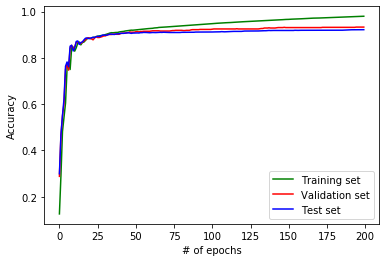

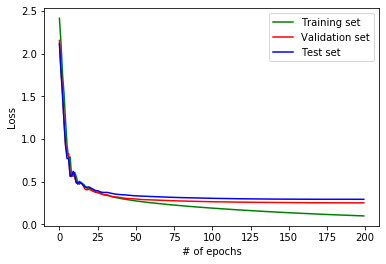

In [26]:
# YOUR CODE HERE
hidden_units = 1000
input_units = 784
output_units = 10
epochs = 200
alpha = 0.9
nu    = 0.00001
# YOUR CODE HERE
datas = loadData()
testData = datas[2].reshape(datas[2].shape[0], -1)
trainData = datas[0].reshape(datas[0].shape[0], -1)
validData = datas[1].reshape(datas[1].shape[0], -1)


#Convert to One Hot
trainTarget_OH, validTarget_OH, testTarget_OH = convertOneHot(trainTarget, validTarget, testTarget)

#Xavier normalization 
var_sigma_h = np.sqrt(2/(input_units + hidden_units))
var_sigma_o = np.sqrt(2/(hidden_units + output_units))
#print("var sigma_h is = ", var_sigma_h)
#print("var sigma_o is = ", var_sigma_o)

#Identify the weight vectors
w_h = np.random.normal(loc=0, scale=var_sigma_h, size = (input_units+1, hidden_units))
w_o = np.random.normal(loc=0, scale=var_sigma_o, size = (hidden_units+1, output_units))

#print("w_h is = \n", w_h, "and the shape of w_h is =", w_h.shape)
#print("w_o is = \n", w_o, "and the shape of w_o is =", w_o.shape)

w_h, w_o, trainingDataAccuracy, validationDataAccuracy, testDataAccuracy, CE_loss_training, CE_loss_validation, CE_loss_test = network_training(trainData, trainTarget_OH, w_h, w_o,alpha,nu,epochs, validData,testData,validTarget_OH,testTarget_OH)


#Plot the accuracies
plt.plot(trainingDataAccuracy, "-g", label = "Training set")
plt.plot(validationDataAccuracy, "-r", label = "Validation set")
plt.plot(testDataAccuracy, "-b", label = "Test set")
plt.ylabel("Accuracy")
plt.xlabel("# of epochs")
plt.legend(loc = "lower right")
plt.show()

#Plot the loss
plt.plot(CE_loss_training, "-g", label = "Training set")
plt.plot(CE_loss_validation, "-r", label = "Validation set")
plt.plot(CE_loss_test, "-b", label = "Test set")
plt.ylabel("Loss")
plt.xlabel("# of epochs")
plt.legend(loc = "upper right")
plt.show()






### MY ANSWER:
#### For accuracy:
As you see below the graph of $ Accuracy $ vs $  epochs $ is given:
<img src="1000hidden_units.png" width="600">
By looking at the graph we can say that:
### @1000 Hidden Units
##### Training set Accuracy     = 97.99%
##### Validation set Accuracy  = 93.30%
##### Test set Accuracy            = 92.18%

By looking at the $ Cross Entropy $ vs $ epochs $ we get the losses of each data set. Below illustrates this graph:
<img src="1000hidden_units_loss.png" width="600">



## Hyperparameter investigation [3 points]

Continue to use $\alpha=0.9$ and $\eta=10^{-5}$.

Test your network with 500 and 1500 hidden nodes and train for 200 epochs. Comment based on the validation accuracy after how many epochs training could be terminated early. 

Plot the training and validation accuracy curves for all three network sizes (500, 1000, 1500) and 200 training epochs, and report the test accuracy for your selected network size and training length. Show the plots and state the final accuracies in the next text cell.

 500 Hidden Units 


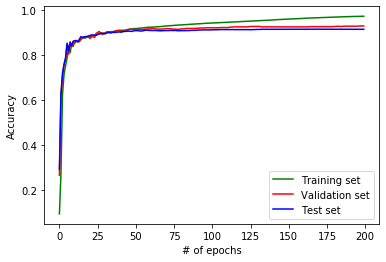

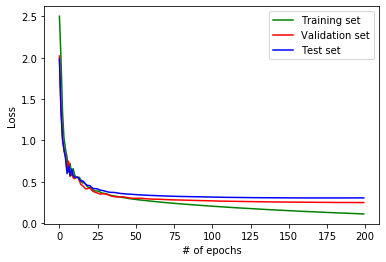

 1000 Hidden Units 


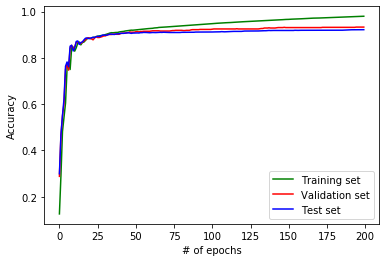

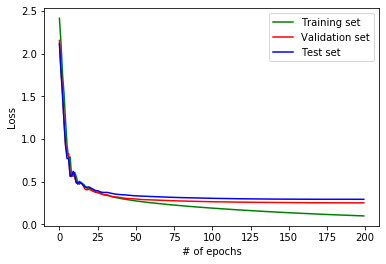

 1500 Hidden Units 


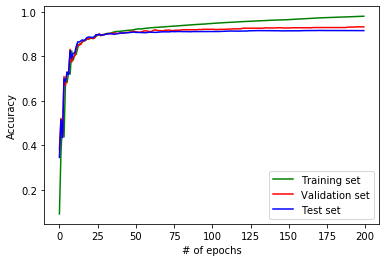

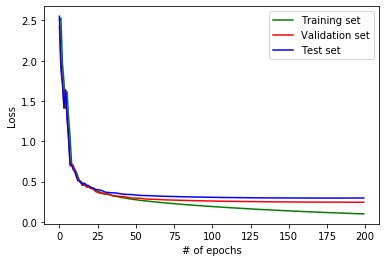

In [28]:
# YOUR CODE HERE

print(" 500 Hidden Units ")

hidden_units = 500
input_units = 784
output_units = 10
epochs = 200
alpha = 0.9
nu    = 0.00001
# YOUR CODE HERE
datas = loadData()
testData = datas[2].reshape(datas[2].shape[0], -1)
trainData = datas[0].reshape(datas[0].shape[0], -1)
validData = datas[1].reshape(datas[1].shape[0], -1)


#Convert to One Hot
trainTarget_OH, validTarget_OH, testTarget_OH = convertOneHot(trainTarget, validTarget, testTarget)

#Xavier normalization 
var_sigma_h = np.sqrt(2/(input_units + hidden_units))
var_sigma_o = np.sqrt(2/(hidden_units + output_units))
#print("var sigma_h is = ", var_sigma_h)
#print("var sigma_o is = ", var_sigma_o)

#Identify the weight vectors
w_h = np.random.normal(loc=0, scale=var_sigma_h, size = (input_units+1, hidden_units))
w_o = np.random.normal(loc=0, scale=var_sigma_o, size = (hidden_units+1, output_units))

#print("w_h is = \n", w_h, "and the shape of w_h is =", w_h.shape)
#print("w_o is = \n", w_o, "and the shape of w_o is =", w_o.shape)

w_h, w_o, trainingDataAccuracy, validationDataAccuracy, testDataAccuracy, CE_loss_training, CE_loss_validation, CE_loss_test = network_training(trainData, trainTarget_OH, w_h, w_o,alpha,nu,epochs, validData,testData,validTarget_OH,testTarget_OH)


#Plot the accuracies
plt.plot(trainingDataAccuracy, "-g", label = "Training set")
plt.plot(validationDataAccuracy, "-r", label = "Validation set")
plt.plot(testDataAccuracy, "-b", label = "Test set")
plt.ylabel("Accuracy")
plt.xlabel("# of epochs")
plt.legend(loc = "lower right")
plt.show()

#Plot the loss
plt.plot(CE_loss_training, "-g", label = "Training set")
plt.plot(CE_loss_validation, "-r", label = "Validation set")
plt.plot(CE_loss_test, "-b", label = "Test set")
plt.ylabel("Loss")
plt.xlabel("# of epochs")
plt.legend(loc = "upper right")
plt.show()

### 500 Units Done

print(" 1000 Hidden Units ")

hidden_units = 1000
input_units = 784
output_units = 10
epochs = 200
alpha = 0.9
nu    = 0.00001
# YOUR CODE HERE
datas = loadData()
testData = datas[2].reshape(datas[2].shape[0], -1)
trainData = datas[0].reshape(datas[0].shape[0], -1)
validData = datas[1].reshape(datas[1].shape[0], -1)


#Convert to One Hot
trainTarget_OH, validTarget_OH, testTarget_OH = convertOneHot(trainTarget, validTarget, testTarget)

#Xavier normalization 
var_sigma_h = np.sqrt(2/(input_units + hidden_units))
var_sigma_o = np.sqrt(2/(hidden_units + output_units))
#print("var sigma_h is = ", var_sigma_h)
#print("var sigma_o is = ", var_sigma_o)

#Identify the weight vectors
w_h = np.random.normal(loc=0, scale=var_sigma_h, size = (input_units+1, hidden_units))
w_o = np.random.normal(loc=0, scale=var_sigma_o, size = (hidden_units+1, output_units))

#print("w_h is = \n", w_h, "and the shape of w_h is =", w_h.shape)
#print("w_o is = \n", w_o, "and the shape of w_o is =", w_o.shape)

w_h, w_o, trainingDataAccuracy, validationDataAccuracy, testDataAccuracy, CE_loss_training, CE_loss_validation, CE_loss_test = network_training(trainData, trainTarget_OH, w_h, w_o,alpha,nu,epochs, validData,testData,validTarget_OH,testTarget_OH)


#Plot the accuracies
plt.plot(trainingDataAccuracy, "-g", label = "Training set")
plt.plot(validationDataAccuracy, "-r", label = "Validation set")
plt.plot(testDataAccuracy, "-b", label = "Test set")
plt.ylabel("Accuracy")
plt.xlabel("# of epochs")
plt.legend(loc = "lower right")
plt.show()

#Plot the loss
plt.plot(CE_loss_training, "-g", label = "Training set")
plt.plot(CE_loss_validation, "-r", label = "Validation set")
plt.plot(CE_loss_test, "-b", label = "Test set")
plt.ylabel("Loss")
plt.xlabel("# of epochs")
plt.legend(loc = "upper right")
plt.show()

##1000 Units Done


print(" 1500 Hidden Units ")

hidden_units = 1500
input_units = 784
output_units = 10
epochs = 200
alpha = 0.9
nu    = 0.00001
# YOUR CODE HERE
datas = loadData()
testData = datas[2].reshape(datas[2].shape[0], -1)
trainData = datas[0].reshape(datas[0].shape[0], -1)
validData = datas[1].reshape(datas[1].shape[0], -1)


#Convert to One Hot
trainTarget_OH, validTarget_OH, testTarget_OH = convertOneHot(trainTarget, validTarget, testTarget)

#Xavier normalization 
var_sigma_h = np.sqrt(2/(input_units + hidden_units))
var_sigma_o = np.sqrt(2/(hidden_units + output_units))
#print("var sigma_h is = ", var_sigma_h)
#print("var sigma_o is = ", var_sigma_o)

#Identify the weight vectors
w_h = np.random.normal(loc=0, scale=var_sigma_h, size = (input_units+1, hidden_units))
w_o = np.random.normal(loc=0, scale=var_sigma_o, size = (hidden_units+1, output_units))

#print("w_h is = \n", w_h, "and the shape of w_h is =", w_h.shape)
#print("w_o is = \n", w_o, "and the shape of w_o is =", w_o.shape)

w_h, w_o, trainingDataAccuracy, validationDataAccuracy, testDataAccuracy, CE_loss_training, CE_loss_validation, CE_loss_test = network_training(trainData, trainTarget_OH, w_h, w_o,alpha,nu,epochs, validData,testData,validTarget_OH,testTarget_OH)


#Plot the accuracies
plt.plot(trainingDataAccuracy, "-g", label = "Training set")
plt.plot(validationDataAccuracy, "-r", label = "Validation set")
plt.plot(testDataAccuracy, "-b", label = "Test set")
plt.ylabel("Accuracy")
plt.xlabel("# of epochs")
plt.legend(loc = "lower right")
plt.show()

#Plot the loss
plt.plot(CE_loss_training, "-g", label = "Training set")
plt.plot(CE_loss_validation, "-r", label = "Validation set")
plt.plot(CE_loss_test, "-b", label = "Test set")
plt.ylabel("Loss")
plt.xlabel("# of epochs")
plt.legend(loc = "upper right")
plt.show()


### MY ANSWER:
We have the graph of 500 units as seen below:
<img src="500hidden_units.png" width="600">
## @500 Hidden units:
##### Training set Accuracy     = 97.325%
##### Validation set Accuracy  = 93.00%
##### Test set Accuracy            = 91.52%

Below you can find the information about the test for 1500 hidden units.
<img src="1000hidden_units.png" width="600">
## @1000 Hidden Units
##### Training set Accuracy     = 97.99%
##### Validation set Accuracy  = 93.30%
##### Test set Accuracy            = 92.18%

Below you can find the information about the test for 1500 hidden units.
<img src="1500hidden_units.png" width="600">
## @1500 Hidden units:
##### Training set Accuracy     = 97.96%
##### Validation set Accuracy  = 93.10%
##### Test set Accuracy            = 91.55%

The above represent the accuracy rates at Epochs = @200. However, we need to show the early termination for Validation accuracy, and these are:
## @500 Hidden units:
@epoch $ 193 $ We got the highest validation accuracy which is $ \%93.1 $ 
## @1000 Hidden Units:
@epoch $ 182 $ We got the highest validation accuracy which is $ \%93.5 $ 
## @1500 Hidden Units:
@epoch $ 188 $ We got the highest validation accuracy which is $ \%93.4 $ 